In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score,\
        recall_score, classification_report, precision_recall_curve,\
        confusion_matrix, auc, roc_curve

In [3]:
from lightgbm import LGBMClassifier
import lightgbm
import  catboost as catb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [4]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#from sklearn.impute import KNNImputer

In [6]:
#from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
#from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
#from sklearn.compose import ColumnTransformer
#import category_encoders as ce

In [7]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [8]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [9]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [10]:
def balance_df_by_target_advance(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [11]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [12]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2 # подсчитываем память потребляемую изначальным датасетом
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns: # проходимся по всем колонкам
        col_type = df[col].dtype  # узнаем тип колонки
        
        if col_type != object:
            c_min = df[col].min() # смотрим минимальное значение признака
            c_max = df[col].max() # смотрим максимальное значение признака
            if str(col_type)[:3] == 'int':  # if int
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # сравниваем с int8
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: # сравниваем с int16 и.т.д.
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: # если был тип object, то меняем его тип на пандасовский тип 'category', на нем разные агрегации данных работают в разы быстрее
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # считаем сколько теперь у нас занято памяти
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))  # и выводим статистику
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [13]:
def choise_features(data, model):
    X = data.drop(columns=['target'])
    y = data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        shuffle=True,
                                                        test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    
    

    #lgb = LGBMClassifier(objective='binary',
     ##                   #n_estimators=50, 
    #                     #max_depth=3, 
    #                     metric = "f1",
    #                     #categorical_feature=cat_feats
    #                    )

    
    model.fit(X_train, y_train)


    evaluate_preds(model, X_train, X_test, y_train, y_test)

    feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                       columns=['feature_name', 'importance'])

    feature_importances.sort_values(by='importance', ascending=False)

    return X_train, X_test, y_train, y_test, feature_importances

In [14]:
def train_evaluate_preds(model, X_train, X_test, y_train, y_test):
    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    
    

    #model_RF = RandomForestClassifier(random_state=21)

    
    model.fit(X_train, y_train)


    evaluate_preds(model, X_train, X_test, y_train, y_test)

    feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                       columns=['feature_name', 'importance'])

    feature_importances.sort_values(by='importance', ascending=False)

    return feature_importances

In [15]:
def target_encoder(X_train, y_train, X_test, encoded):
    Form = pd.concat([X_train[encoded], y_train], axis=1)
    Mask = pd.DataFrame(Form.groupby(by=encoded)['target'].mean()).\
           rename(columns={"target": f"{encoded}_mean"})
    X_train = pd.merge(X_train, Mask, how='left', on=encoded)
    X_test = pd.merge(X_test, Mask, how='left', on=encoded)
    
    return X_train, X_test

In [16]:
def log_columns(df, big_nunique_features):
    for col in big_nunique_features:
        const = np.min(df[col])
        if const > 0:
            const = 0
        else:
            const -= 0.1
        df[col] = np.log(df[col]-const+0.001)

In [17]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kfold_cv = KFold(n_splits=3, shuffle=True, random_state=21)

def run_cv(estimator, cv, X, y, scoring='f1_macro',  model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

In [19]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

In [20]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 1039.31 MB
Memory usage after optimization is: 502.05 MB
Decreased by 51.7%
Memory usage of dataframe is 692.88 MB
Memory usage after optimization is: 342.31 MB
Decreased by 50.6%


In [21]:
train_df8 = train_df[train_df['vas_id']==8]
test_df8 = test_df[test_df['vas_id']==8]

In [22]:
train_df8.target.value_counts(normalize=True)

0.0    0.974776
1.0    0.025224
Name: target, dtype: float64

In [23]:
test_df8.target.value_counts(normalize=True)

0.0    0.97284
1.0    0.02716
Name: target, dtype: float64

In [24]:
train_df8.head(10)

,id,vas_id,buy_time_x,0,1,2,3,4,5,6,...,vas_id_08,vas_id_09,month,day,weekofyear,time_max,novelty,vas_id_day,is_action,target
219,762271,8.0,1537736400,-96.799973,17.670887,-110.740784,-34.936798,-116.158249,-56.041790,-16.086180,...,1,0,9,267,39,1546203600,8467200,0,0,0.0
237,686694,8.0,1534712400,-96.799973,-61.289112,-100.740784,-48.956799,-106.158249,-70.061790,-16.086180,...,1,0,8,232,34,1546203600,11491200,35,0,0.0
246,160420,8.0,1538946000,27.750029,56.960888,59.559216,146.703201,54.141754,125.598213,40.683819,...,1,0,10,281,41,1546203600,7257600,0,0,0.0
270,3309430,8.0,1534712400,-96.799973,211.720886,-110.740784,192.163208,72.411751,359.628204,-16.086180,...,1,0,8,232,34,1546203600,11491200,0,0,0.0
431,975511,8.0,1542574800,-96.799973,-162.419113,-110.740784,-215.026794,-116.158249,-236.131790,-16.086180,...,1,0,11,323,47,1546203600,3628800,0,1,1.0
464,1981446,8.0,1532293200,7.020029,7.100888,-5.230786,-40.426800,-10.648247,-61.531788,-16.086180,...,1,0,7,204,30,1546203600,13910400,0,0,0.0
527,3690397,8.0,1535317200,-32.529972,169.660889,-44.800785,125.493202,-50.218246,104.388214,-10.156180,...,1,0,8,239,35,1546203600,10886400,0,0,0.0
571,1796657,8.0,1532293200,-7.829971,-217.529114,-15.840786,-241.326797,-21.258245,-262.431793,-16.086180,...,1,0,7,204,30,1546203600,13910400,0,0,0.0
644,1979759,8.0,1534712400,-96.799973,-111.569115,-110.740784,-130.276794,-116.158249,-151.381790,-16.086180,...,1,0,8,232,34,1546203600,11491200,0,0,0.0
656,1924819,8.0,1542574800,384.220032,669.750916,403.329224,729.863220,397.911743,708.758240,-16.086180,...,1,0,11,323,47,1546203600,3628800,0,1,1.0


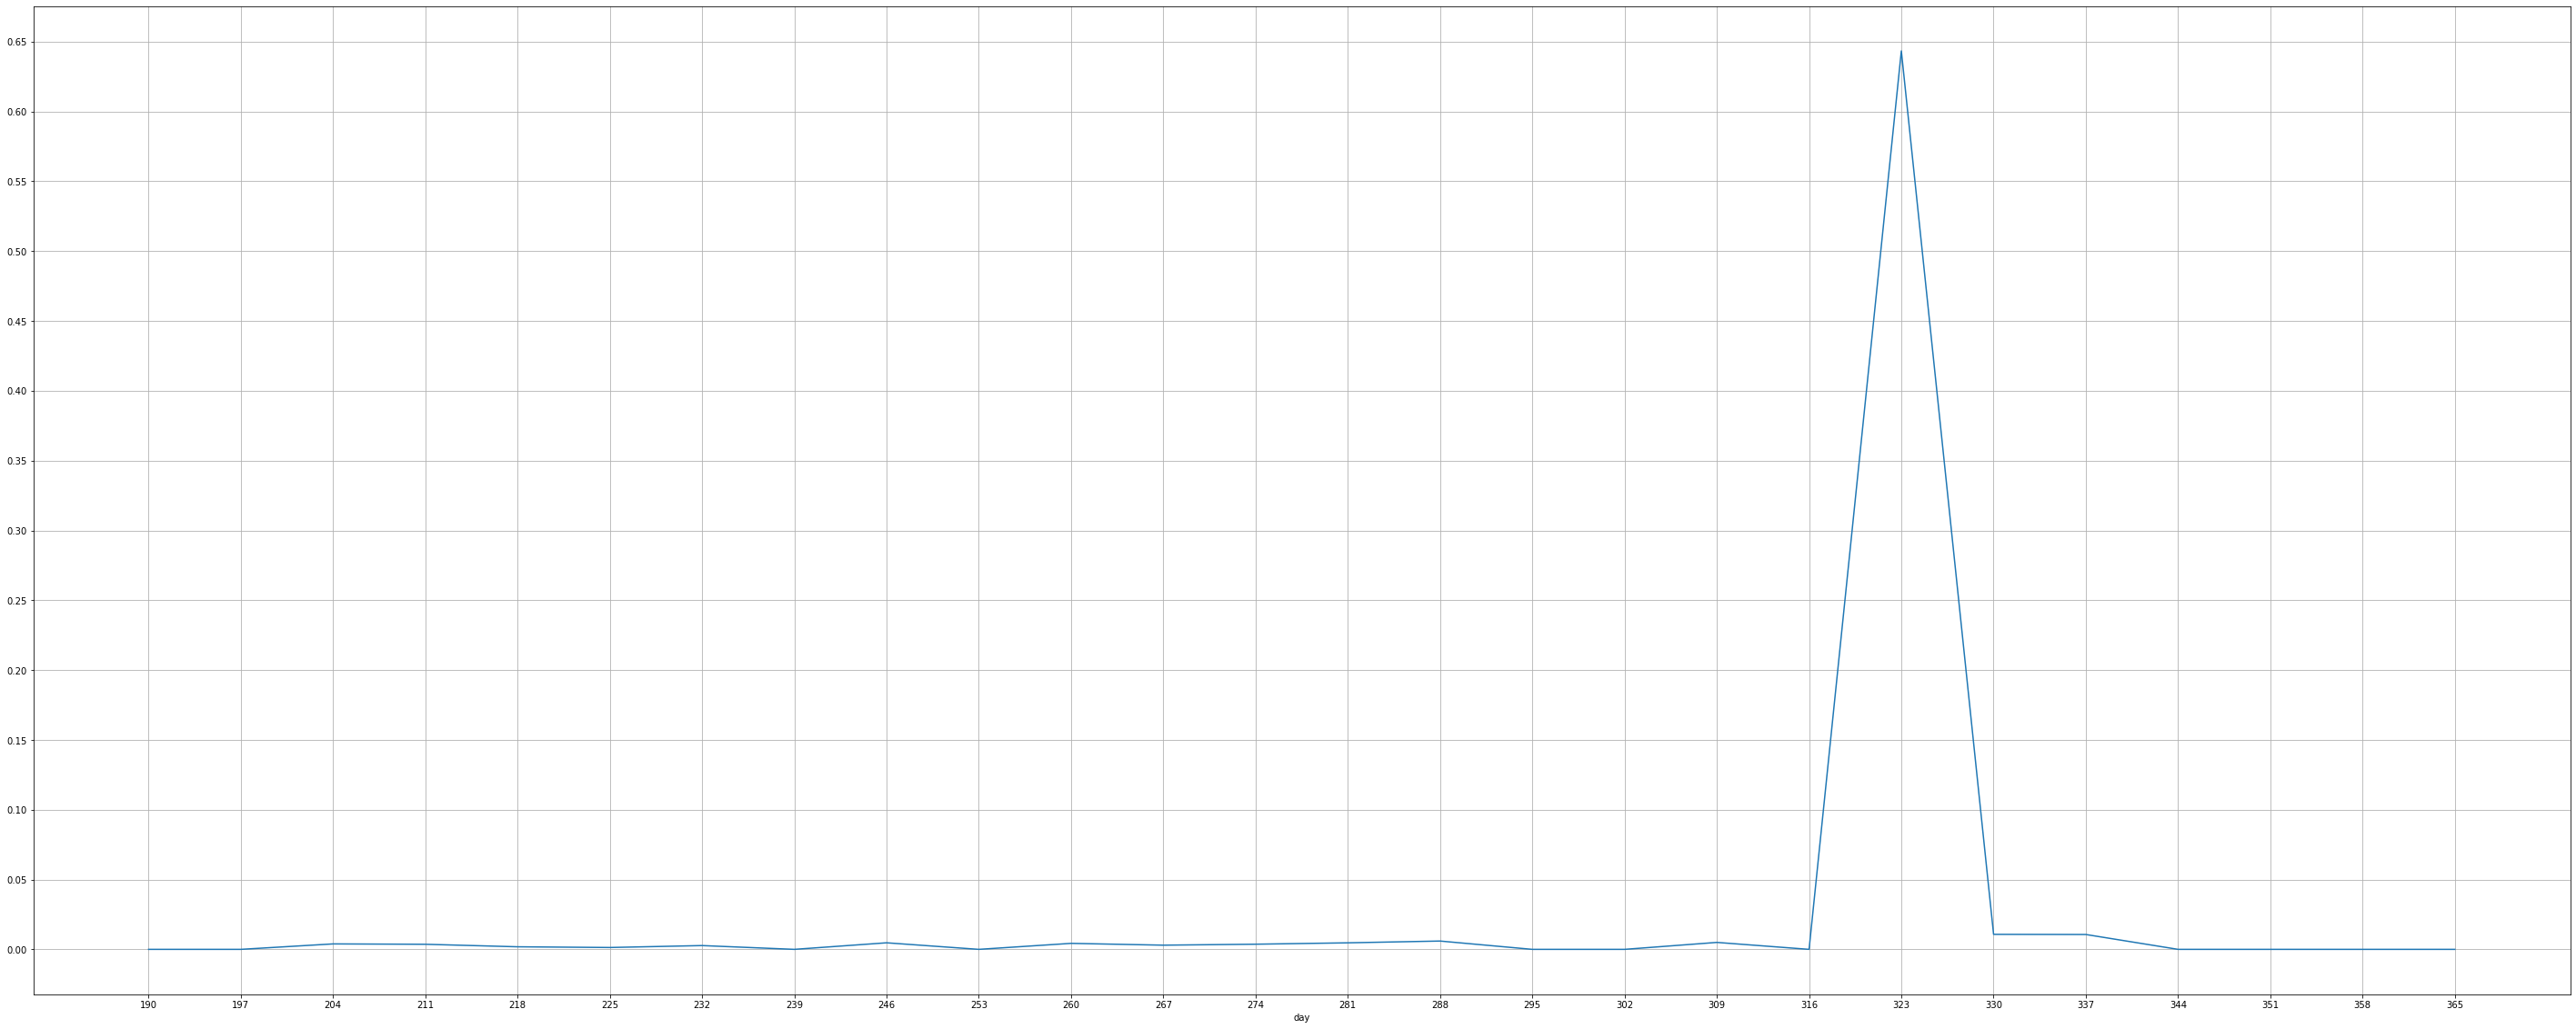

In [26]:
plt.figure(figsize=(50, 20))
train_df8.groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
plt.xticks(train_df8['day'].unique())
plt.yticks(np.arange(0, 0.7, 0.05))
plt.grid()
plt.show()

Выброс с 317 по 344 день.

# Разбиение на  train  и  test

In [25]:
TARGET_NAME = 'target'

In [26]:
X_train = train_df8.drop(columns=[TARGET_NAME])
y_train = train_df8[TARGET_NAME]
X_test = test_df8.drop(columns=[TARGET_NAME])
y_test = test_df8[TARGET_NAME]

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0.0    0.974776
1.0    0.025224
Name: target, dtype: float64

0.0    0.97284
1.0    0.02716
Name: target, dtype: float64

In [27]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0.0    7845
1.0    7714
Name: target, dtype: int64

In [28]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

# Поиск категориальных признаков среди вещественных

In [31]:
df_numerical = X_train.select_dtypes(include = [np.number])
df_categorical = X_train.select_dtypes(exclude = [np.number])

In [32]:
# Ищу признаки категориальные среди вещественных
select_spy = pd.DataFrame(df_numerical.nunique())

In [33]:
list_spy = select_spy.loc[select_spy[0] < 11].index.to_list()

In [34]:
list_spy.remove('vas_id')

In [35]:
#df_categorical = df_all[list_spy]

In [36]:
#df_numerical.drop(labels=list_spy, axis=1, inplace = True)
#вырезаем эти колонки из количественных данных

In [37]:
#df_numerical.drop(labels=['target'], axis=1, inplace = True)

In [38]:
# где у нас нули
#for i in df_numerical.columns:
#    print(i, df4[i][df4[i]==0].count())

In [39]:
# Проверка
Categorical_features = X_train_balanced.select_dtypes(exclude=[np.number])

In [40]:
cat_feats = Categorical_features.columns.to_list()

In [41]:
cat_feats

[]

In [42]:
#df4[list_spy] = df4[list_spy].astype('object')

In [43]:
#categorical_features = df4.select_dtypes(include=['object']).columns.to_list()

In [44]:
list_spy = ['15', '16', '17', '23', '24', '26', '27', '29', '30', '31', '32', '33', '35', '57',
     '65', '75', '81', '85', '95', '131', '132', '139', '154', '155', '179', '192', '194', '195',
     '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '212', '216',
     '218', '220', '221', '252', 'month']

# Выбор модели

In [33]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

38.645320197044335

In [65]:
disbalance2 = y_train_balanced.value_counts()[0] / y_train_balanced.value_counts()[1]
disbalance2

1.016982110448535

scale_pos_weight не помог

# XGBClassifier

In [45]:
# manually handling imbalance. Below is same as computing float(18501)/392318 
#on the trainig dataset.
# We are going to inversely assign the weights
weight_ratio = float(len(y_train_balanced[y_train_balanced == 0]))/float(len(y_train_balanced[y_train_balanced == 1]))
w_array = np.array([1]*y_train_balanced.shape[0])
w_array[y_train_balanced==1] = weight_ratio
w_array[y_train_balanced==0] = 1- weight_ratio

sample_weight=w_array не повлиял на результат

In [41]:
model_xgb = xgb.XGBClassifier(random_state=21)

In [42]:
feature_importances = train_evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

0.0    0.974776
1.0    0.025224
Name: target, dtype: float64

0.0    0.97284
1.0    0.02716
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7845
         1.0       1.00      1.00      1.00       203

    accuracy                           1.00      8048
   macro avg       1.00      1.00      1.00      8048
weighted avg       1.00      1.00      1.00      8048

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5158
         1.0       0.70      0.69      0.69       144

    accuracy                           0.98      5302
   macro avg       0.84      0.84      0.84      5302
weighted avg       0.98      0.98      0.98      5302

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     5115   43
1.0      

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


macro avg       0.88      0.65      0.71     87015

In [48]:
#run_cv(model_xgb, kfold_cv, X_train, y_train, model_name="model_xgb");

model_xgb: f1_macro = 0.56 (+/- 0.00)


In [49]:
model_xgb = xgb.XGBClassifier(random_state=21)

In [50]:
feature_importances = train_evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.50421
1.0    0.49579
Name: target, dtype: float64

0.0    0.97284
1.0    0.02716
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:44:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7845
         1.0       1.00      1.00      1.00      7714

    accuracy                           1.00     15559
   macro avg       1.00      1.00      1.00     15559
weighted avg       1.00      1.00      1.00     15559

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5158
         1.0       0.67      0.76      0.71       144

    accuracy                           0.98      5302
   macro avg       0.83      0.88      0.85      5302
weighted avg       0.98      0.98      0.98      5302

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     5104   54
1.0      

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


macro avg       0.77      0.87      0.81     28204

Для оценки качества модели будем использовать кросс-валидацию по 3-ем фолдам.

In [51]:
#run_cv(model_xgb, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_xgb");

model_xgb: f1_macro = 0.98 (+/- 0.00)



In [52]:
#show_learning_curve_plot(model_xgb, X_train_balanced, y_train_balanced)

# LGBMClassifier

In [53]:
model_lgbm = LGBMClassifier(random_state=21)

Регуляризация не повлияла на результат

In [54]:
feature_importances = train_evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

0.0    0.974776
1.0    0.025224
Name: target, dtype: float64

0.0    0.97284
1.0    0.02716
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7845
         1.0       1.00      1.00      1.00       203

    accuracy                           1.00      8048
   macro avg       1.00      1.00      1.00      8048
weighted avg       1.00      1.00      1.00      8048

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5158
         1.0       0.67      0.59      0.63       144

    accuracy                           0.98      5302
   macro avg       0.83      0.79      0.81      5302
weighted avg       0.98      0.98      0.98      5302

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     5116   42
1.0       59   85


 macro avg       0.87      0.65      0.71     75129

In [55]:
#run_cv(model_lgbm, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_lgbm");

model_lgbm: f1 = 0.61 (+/- 0.01)

In [56]:
model_lgbm = LGBMClassifier(random_state=21)

In [57]:
feature_importances = train_evaluate_preds(model_lgbm, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.50421
1.0    0.49579
Name: target, dtype: float64

0.0    0.97284
1.0    0.02716
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7845
         1.0       1.00      1.00      1.00      7714

    accuracy                           1.00     15559
   macro avg       1.00      1.00      1.00     15559
weighted avg       1.00      1.00      1.00     15559

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5158
         1.0       0.69      0.78      0.74       144

    accuracy                           0.98      5302
   macro avg       0.84      0.89      0.86      5302
weighted avg       0.99      0.98      0.99      5302

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     5108   50
1.0       31  113


macro avg       0.78      0.87      0.82     28204

In [58]:
#run_cv(model_lgbm, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_lgbm");

model_lgbm: f1_macro = 0.99 (+/- 0.00)

In [59]:
#show_learning_curve_plot(model_lgbm, X_train_balanced, y_train_balanced)

# CatBoostClassifier

In [34]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     #'cat_features': [],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [45]:
model_catb = catb.CatBoostClassifier(**frozen_params)

In [46]:
feature_importances = train_evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

0.0    0.974776
1.0    0.025224
Name: target, dtype: float64

0.0    0.97284
1.0    0.02716
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      7845
         1.0       0.77      1.00      0.87       203

    accuracy                           0.99      8048
   macro avg       0.88      1.00      0.93      8048
weighted avg       0.99      0.99      0.99      8048

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5158
         1.0       0.66      0.91      0.77       144

    accuracy                           0.99      5302
   macro avg       0.83      0.95      0.88      5302
weighted avg       0.99      0.99      0.99      5302

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     5092   66
1.0       13  131


macro avg       0.76      0.83      0.79     75129

In [64]:
run_cv(model_catb, kfold_cv, X_train, y_train, model_name="model_catb");

model_catb: f1_macro = 0.87 (+/- 0.01)


model_catb: f1_macro = 0.87 (+/- 0.01)


In [66]:
frozen_params2 = {
     'class_weights':[1, disbalance2], 
     'silent':True,
     'random_state':21,
     #'cat_features': ['month', 'clasters_3', 'clasters_7'],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [67]:
model_catb2 = catb.CatBoostClassifier(**frozen_params2)

In [68]:
feature_importances = train_evaluate_preds(model_catb2, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.50421
1.0    0.49579
Name: target, dtype: float64

0.0    0.97284
1.0    0.02716
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7845
         1.0       1.00      1.00      1.00      7714

    accuracy                           1.00     15559
   macro avg       1.00      1.00      1.00     15559
weighted avg       1.00      1.00      1.00     15559

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5158
         1.0       0.66      0.90      0.76       144

    accuracy                           0.98      5302
   macro avg       0.83      0.94      0.88      5302
weighted avg       0.99      0.98      0.99      5302

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     5093   65
1.0       15  129


macro avg       0.78      0.87      0.81     28204

In [79]:
run_cv(model_catb2, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_catb");

model_catb: f1_macro = 0.99 (+/- 0.00)


model_catb: f1_macro = 0.99 (+/- 0.00)





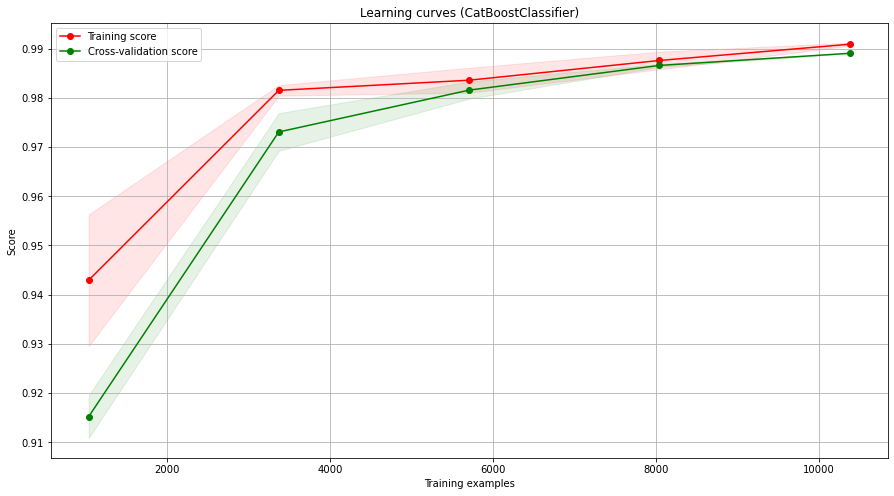

In [80]:
show_learning_curve_plot(model_catb, X_train_balanced, y_train_balanced)

# RandomForestClassifier

In [71]:
model_RF = RandomForestClassifier(random_state=21, class_weight={0:.57, 1:.43})

RandomForestClassifier без ccp_alpha дает полное переобучение на трейне, ввел коэффициент.

In [72]:
feature_importances = train_evaluate_preds(model_RF, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.50421
1.0    0.49579
Name: target, dtype: float64

0.0    0.97284
1.0    0.02716
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7845
         1.0       1.00      1.00      1.00      7714

    accuracy                           1.00     15559
   macro avg       1.00      1.00      1.00     15559
weighted avg       1.00      1.00      1.00     15559

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5158
         1.0       0.70      0.76      0.73       144

    accuracy                           0.98      5302
   macro avg       0.84      0.88      0.86      5302
weighted avg       0.99      0.98      0.98      5302

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     5110   48
1.0       34  110


macro avg       0.79      0.83      0.81     75129

In [73]:
#run_cv(model_RF, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_RF");

In [74]:
model_RF2 = RandomForestClassifier(random_state=21, class_weight={0:.57, 1:.43})

In [75]:
feature_importances2 = train_evaluate_preds(model_RF, X_train, X_test, y_train, y_test)

0.0    0.974776
1.0    0.025224
Name: target, dtype: float64

0.0    0.97284
1.0    0.02716
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7845
         1.0       1.00      1.00      1.00       203

    accuracy                           1.00      8048
   macro avg       1.00      1.00      1.00      8048
weighted avg       1.00      1.00      1.00      8048

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5158
         1.0       0.69      0.71      0.70       144

    accuracy                           0.98      5302
   macro avg       0.84      0.85      0.85      5302
weighted avg       0.98      0.98      0.98      5302

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     5113   45
1.0       42  102


macro avg       0.49      0.50      0.50     87015

In [76]:
#run_cv(model_RF2, kfold_cv, X_train, y_train, model_name="model_RF");

model_RF2: f1 = 0.52 (+/- 0.01)


In [77]:
#show_learning_curve_plot(model_RF, X_train_balanced, y_train_balanced)

По результатам отборочных туров, главным тренером команды назначен CatBoostClassifier на несбалансированных данных.

# Выбор метода балансировки датасета

In [81]:
df_balanced_tomek = balance_df_by_target_advance(df_for_balancing, 'target', method='tomek')

In [82]:
X_train_tomek = df_balanced_tomek.drop(columns=TARGET_NAME)
y_train_tomek = df_balanced_tomek[TARGET_NAME]

In [83]:
disbalance_t = y_train_tomek.value_counts()[0] / y_train_tomek.value_counts()[1]
disbalance_t

38.33990147783251

In [84]:
frozen_params_t = {
     'class_weights':[1, disbalance_t], 
     'silent':True,
     'random_state':21,
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [85]:
model_catb_t = catb.CatBoostClassifier(**frozen_params_t)

In [86]:
feature_importances = train_evaluate_preds(model_catb_t, X_train_tomek, X_test, y_train_tomek, y_test)

0.0    0.974581
1.0    0.025419
Name: target, dtype: float64

0.0    0.97284
1.0    0.02716
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      7783
         1.0       0.80      1.00      0.89       203

    accuracy                           0.99      7986
   macro avg       0.90      1.00      0.94      7986
weighted avg       0.99      0.99      0.99      7986

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5158
         1.0       0.66      0.91      0.77       144

    accuracy                           0.99      5302
   macro avg       0.83      0.95      0.88      5302
weighted avg       0.99      0.99      0.99      5302

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     5092   66
1.0       13  131


In [87]:
df_smote = balance_df_by_target_advance(df_for_balancing, 'target', method='smote')

In [88]:
X_train_smote= df_smote.drop(columns=TARGET_NAME)
y_train_smote = df_smote[TARGET_NAME]

In [89]:
disbalance_s = y_train_smote.value_counts()[0] / y_train_smote.value_counts()[1]
disbalance_s

1.0

In [90]:
frozen_params_s = {
     'class_weights':[1, disbalance_s], 
     'silent':True,
     'random_state':21,
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [91]:
model_catb_s = catb.CatBoostClassifier(**frozen_params_s)

In [92]:
feature_importances = train_evaluate_preds(model_catb_s, X_train_smote, X_test, y_train_smote, y_test)

1.0    0.5
0.0    0.5
Name: target, dtype: float64

0.0    0.97284
1.0    0.02716
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7845
         1.0       1.00      1.00      1.00      7845

    accuracy                           1.00     15690
   macro avg       1.00      1.00      1.00     15690
weighted avg       1.00      1.00      1.00     15690

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5158
         1.0       0.66      0.81      0.73       144

    accuracy                           0.98      5302
   macro avg       0.83      0.90      0.86      5302
weighted avg       0.99      0.98      0.98      5302

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     5098   60
1.0       27  117


In [ ]:
#run_cv(model_catb_s, kfold_cv, X_train_smote, y_train_smote, model_name="model_catb");

In [ ]:
#fea_imp = feature_importances[feature_importances['importance'] > 0]['feature_name'].to_list()

In [ ]:
#feature_importances = train_evaluate_preds(model_catb_s, X_train_smote[fea_imp], X_test[fea_imp], y_train_smote, y_test)

In [ ]:
#X_train = X_train_smote[fea_imp]
#X_test = X_test[fea_imp]
#y_train = y_train_smote

# Удаление признаков

In [47]:
feature_importances = train_evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

0.0    0.974776
1.0    0.025224
Name: target, dtype: float64

0.0    0.97284
1.0    0.02716
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      7845
         1.0       0.77      1.00      0.87       203

    accuracy                           0.99      8048
   macro avg       0.88      1.00      0.93      8048
weighted avg       0.99      0.99      0.99      8048

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5158
         1.0       0.66      0.91      0.77       144

    accuracy                           0.99      5302
   macro avg       0.83      0.95      0.88      5302
weighted avg       0.99      0.99      0.99      5302

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     5092   66
1.0       13  131


In [48]:
fea_imp = feature_importances[feature_importances['importance'] > 0]['feature_name'].to_list()

In [49]:
len(fea_imp)

220

In [50]:
X_train.shape

(8048, 272)

In [52]:
feature_importances = train_evaluate_preds(model_catb, X_train[fea_imp], X_test[fea_imp], y_train, y_test)

0.0    0.974776
1.0    0.025224
Name: target, dtype: float64

0.0    0.97284
1.0    0.02716
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      7845
         1.0       0.78      1.00      0.88       203

    accuracy                           0.99      8048
   macro avg       0.89      1.00      0.94      8048
weighted avg       0.99      0.99      0.99      8048

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5158
         1.0       0.66      0.91      0.77       144

    accuracy                           0.99      5302
   macro avg       0.83      0.95      0.88      5302
weighted avg       0.99      0.99      0.99      5302

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     5092   66
1.0       13  131


In [ ]:
#X_train = X_train[fea_imp]
#X_test = X_test[fea_imp]

Чемпионат был длинный и часть игроков померла а часть еле дышит. Вызываю санитаров.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [53]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [54]:
lr = LinearRegression()
#select 10 the most informative features
rfe = RFE(lr)
selector = rfe.fit(X_train, y_train)

In [55]:
selector.ranking_

array([125,   1,   1,   1,  73,   1,  74,   1,  77,   1, 103,   1,  70,
         1,   1,   1,  54,   1,   1,   1,   1,   1,   1,   1,  96,   1,
         1,   1,  50,  71,   1,   1,   1,   1,   1,   1,   1,  87,   1,
        14, 119,   1,   1,   1,  24,  69,   1,   1,   1,   1,  75,  99,
        98,   1,   1,  38,  34,   1,  35,  10,   1, 116,  91,   1,   1,
         1,   1,   1,   1,   1,   1,  76,  30,   1,   1,   1,   1,  79,
        26,  16,  17,   1,   1,   1,   2,  18,   1,  86,  27,  33,   1,
         1,  72,  57,   1,   1,   1,  58,  32, 100,  44,   1, 118, 124,
         1,  12,  39,  15,  11,  43,   4,  53, 117,   1,  85,   1,   1,
         1,   1,   1, 109,   1,   1,  67,   1,  89,   1,   1,   1,   1,
         1,   1,  22,  56,   1,   1,   1, 104,  40,   1,   1,   1,  37,
        25,   1,   1,   1,  95,  51,   9,   8,   1,   1,   1,   1,   1,
         1,   1,   7,   1,   1,  41,   1,   1,   1,   1,   1,   1,  45,
        88,  68,  46,  29,  31,  28,  55,  13,   1,   1,   1,   

In [56]:
value = np.array(X_train.columns.to_list())
mask = selector.support_
last_col = list(value[mask])
last_col.extend(['id'])
X_train_short = X_train[last_col]

In [57]:
X_test_short = X_test[last_col]

In [59]:
feature_importances = train_evaluate_preds(model_catb, X_train_short, X_test_short, y_train, y_test)

0.0    0.974776
1.0    0.025224
Name: target, dtype: float64

0.0    0.97284
1.0    0.02716
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      7845
         1.0       0.78      1.00      0.88       203

    accuracy                           0.99      8048
   macro avg       0.89      1.00      0.94      8048
weighted avg       0.99      0.99      0.99      8048

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5158
         1.0       0.67      0.90      0.77       144

    accuracy                           0.99      5302
   macro avg       0.83      0.94      0.88      5302
weighted avg       0.99      0.99      0.99      5302

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     5094   64
1.0       15  129


In [60]:
feature_importances = train_evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

0.0    0.974776
1.0    0.025224
Name: target, dtype: float64

0.0    0.97284
1.0    0.02716
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      7845
         1.0       0.77      1.00      0.87       203

    accuracy                           0.99      8048
   macro avg       0.88      1.00      0.93      8048
weighted avg       0.99      0.99      0.99      8048

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5158
         1.0       0.66      0.91      0.77       144

    accuracy                           0.99      5302
   macro avg       0.83      0.95      0.88      5302
weighted avg       0.99      0.99      0.99      5302

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     5092   66
1.0       13  131


/home/jb/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


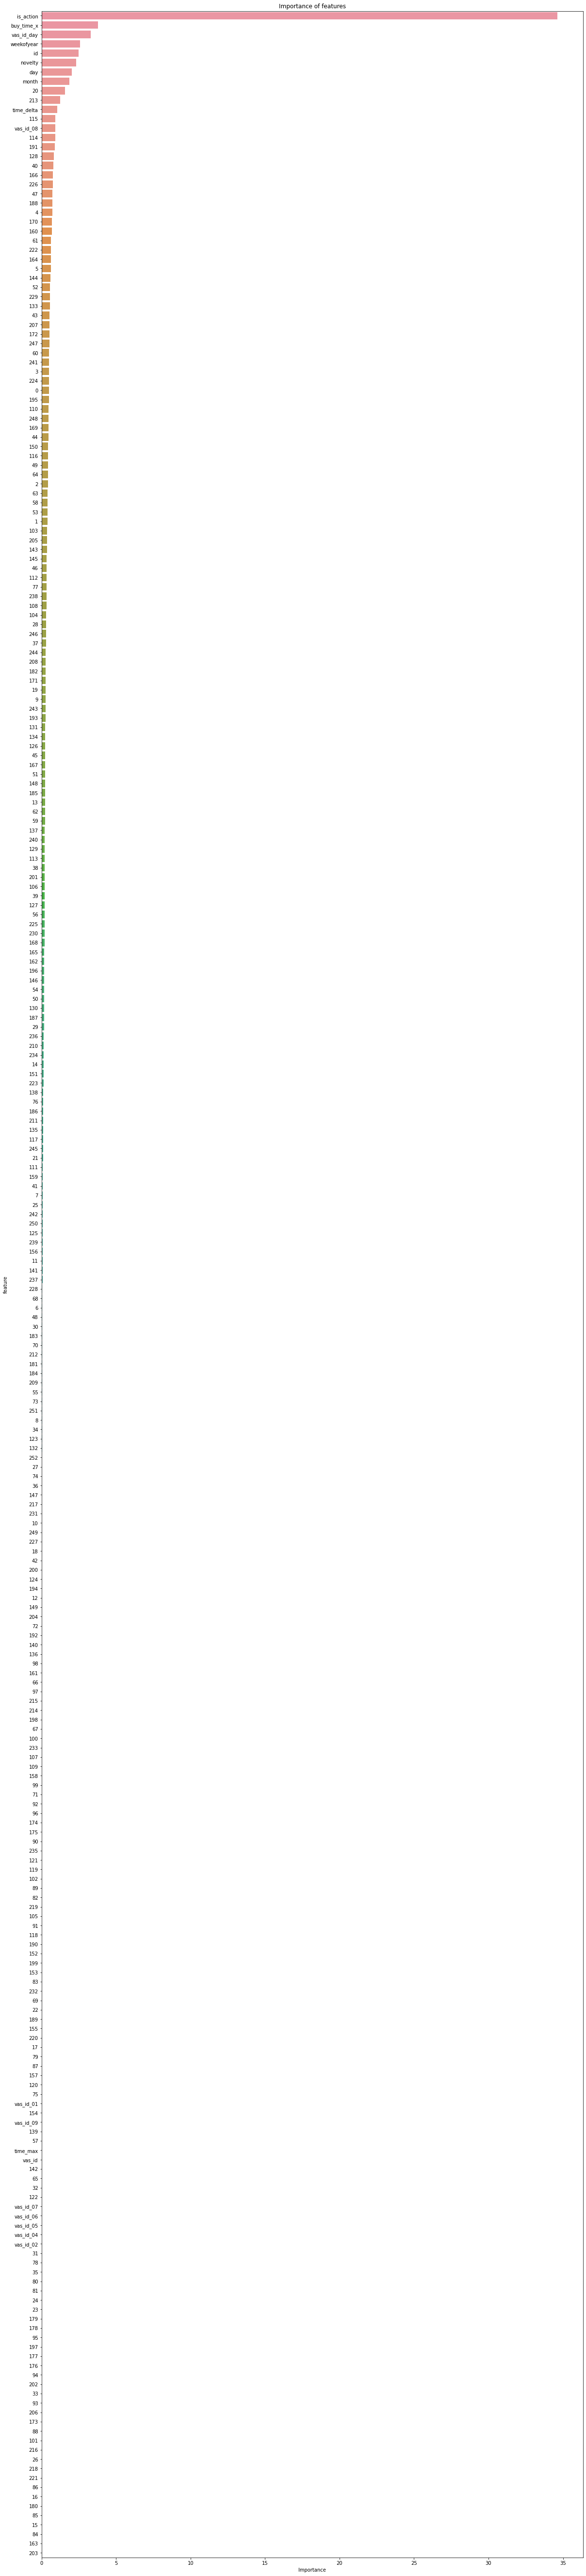

['is_action', 'buy_time_x', 'vas_id_day', 'weekofyear', 'id']

In [61]:
show_feature_importances(feature_importances['feature_name'], feature_importances['importance'], get_top = 5)

# SHAP

In [62]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [64]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model_catb)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

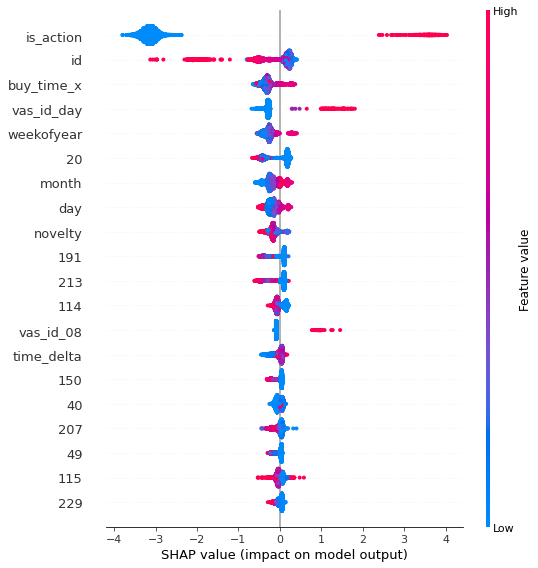

In [66]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Как его читать:

    значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
    чем толще линия на графике, тем больше таких точек наблюдения
    чем краснее точка на графике, тем выше значения признака в ней


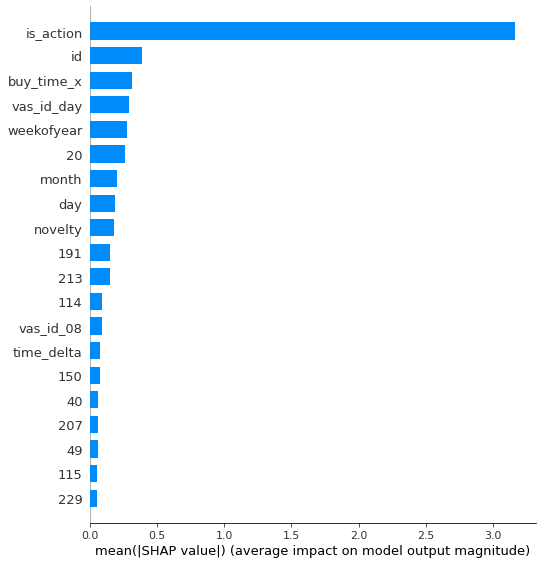

In [67]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [29]:
# Закладка
train_df8 = pd.concat([X_train, y_train], axis=1)
test_df8 = pd.concat([X_test, y_test], axis=1)
train_df8.to_csv('train_df8.csv', index=False)
test_df8.to_csv('test_df8.csv', index=False)

In [30]:
train_df8 = pd.read_csv('train_df8.csv')
test_df8 = pd.read_csv('test_df8.csv')
X_test = test_df8.drop(columns=['target'])
y_test = test_df8['target']
X_train = train_df8.drop(columns=['target'])
y_train = train_df8['target']

# Подбор гиперпараметров

In [70]:
from matplotlib import pyplot

Исследование количества деревьев


In [71]:
# get a list of models to evaluate
def get_models():
    models = dict()
    trees = [50, 100, 200, 500, 1000, 1500]
    for n in trees:
        models[str(n)] = catb.CatBoostClassifier(random_state = 21, iterations=n, silent = True)
    return models

In [72]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [73]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>50 0.856 (0.023)
>100 0.850 (0.023)
>200 0.852 (0.021)
>500 0.855 (0.020)
>1000 0.863 (0.014)
>1500 0.870 (0.012)


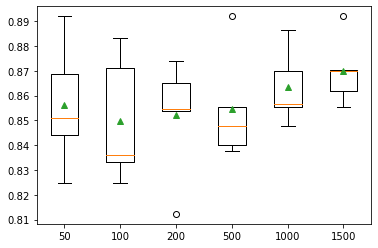

In [74]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Исследование глубины дерева


In [75]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in [2, 4, 6, 8, 10]:
        models[str(i)] = catb.CatBoostClassifier(max_depth=i, num_leaves=2**i,
                                            random_state=21, silent = True)
    return models

In [76]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [77]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>2 0.864 (0.017)
>4 0.867 (0.031)
>6 0.863 (0.014)
>8 0.846 (0.026)
>10 0.845 (0.022)


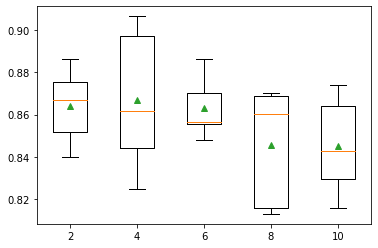

In [78]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Исследование скорости обучения

In [79]:
# get a list of models to evaluate
def get_models():
    models = dict()
    rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
    for r in rates:
        key = '%.4f' % r
        models[key] = catb.CatBoostClassifier(learning_rate=r,
                                            random_state=21, silent = True)
    return models

In [80]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [81]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>0.0001 0.797 (0.062)
>0.0010 0.849 (0.011)
>0.0100 0.849 (0.014)
>0.1000 0.849 (0.021)
>1.0000 0.844 (0.020)


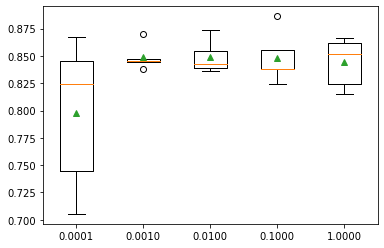

In [82]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Исследование регуляризации

In [83]:
# get a list of models to evaluate
def get_models():
    models = dict()
    types = [0.1,1,2,4,8]
    for t in types:
        models[t] = catb.CatBoostClassifier(l2_leaf_reg=t,
                                            random_state=21, silent=True)
    return models

In [84]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [85]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>0.1 0.840 (0.015)
>1 0.857 (0.012)
>2 0.853 (0.013)
>4 0.857 (0.021)
>8 0.846 (0.019)


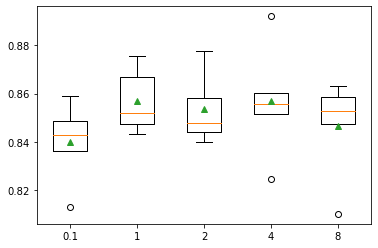

In [86]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [88]:
params = {'n_estimators':[1500, 2000],
          'max_depth':[2, 3]}

In [41]:
cv=KFold(n_splits=5, random_state=21, shuffle=True)

In [90]:
model_catb = catb.CatBoostClassifier(**frozen_params)

In [91]:
%%time

grid_search = model_catb.randomized_search(params, X_train, y_train, n_iter = 50, cv = cv, stratified = True, plot = True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.92720189
bestIteration = 0

0:	loss: 0.9272019	best: 0.9272019 (0)	total: 644ms	remaining: 1.93s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.92720189
bestIteration = 0

1:	loss: 0.9272019	best: 0.9272019 (0)	total: 1.07s	remaining: 1.07s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.92720189
bestIteration = 0

2:	loss: 0.9272019	best: 0.9272019 (0)	total: 1.77s	remaining: 589ms
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.92720189
bestIteration = 0

3:	loss: 0.9272019	best: 0.9272019 (0)	total: 2.41s	remaining: 0us
Estimating final quality...
Stopped by overfitting detector  (60 iterations wait)
CPU times: user 47 s, sys: 2.38 s, total: 49.4 s
Wall time: 19.4 s


In [45]:
best_model = catb.CatBoostClassifier(**frozen_params, max_depth=2, n_estimators=1500)

In [46]:
best_model.fit(X_train, y_train)

In [47]:
evaluate_preds(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      7845
         1.0       0.65      1.00      0.79       203

    accuracy                           0.99      8048
   macro avg       0.83      0.99      0.89      8048
weighted avg       0.99      0.99      0.99      8048

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5158
         1.0       0.66      0.91      0.76       144

    accuracy                           0.98      5302
   macro avg       0.83      0.95      0.88      5302
weighted avg       0.99      0.98      0.99      5302

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     5090   68
1.0       13  131


In [48]:
run_cv(best_model, kfold_cv, X_train, y_train, model_name="best_model");

best_model: f1_macro = 0.87 (+/- 0.01)


# Снижение степени переобучения

In [38]:
params = {'l2_leaf_reg': [3, 4, 5],
         'learning_rate': [0.001]
         }

In [39]:
best_model = catb.CatBoostClassifier(**frozen_params)

In [42]:
grid_search = best_model.randomized_search(params, X_train, y_train, n_iter = 50, cv = cv, stratified = True, plot = True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.92720189
bestIteration = 0

0:	loss: 0.9272019	best: 0.9272019 (0)	total: 1.9s	remaining: 3.8s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.92720189
bestIteration = 0

1:	loss: 0.9272019	best: 0.9272019 (0)	total: 3.57s	remaining: 1.79s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.92720189
bestIteration = 0

2:	loss: 0.9272019	best: 0.9272019 (0)	total: 5.24s	remaining: 0us
Estimating final quality...
Stopped by overfitting detector  (60 iterations wait)


Поисковые сетки ничего не знают о требованиях Мегафона к average: macro, и ищут взвешенные метрики. Придется обломиться с поиском.

In [35]:
best_model = catb.CatBoostClassifier(**frozen_params, learning_rate = 0.001)

In [36]:
feature_importances = train_evaluate_preds(best_model, X_train, X_test, y_train, y_test)

0.0    0.974776
1.0    0.025224
Name: target, dtype: float64

0.0    0.97284
1.0    0.02716
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      7845
         1.0       0.63      0.91      0.75       203

    accuracy                           0.98      8048
   macro avg       0.82      0.95      0.87      8048
weighted avg       0.99      0.98      0.99      8048

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5158
         1.0       0.66      0.92      0.77       144

    accuracy                           0.99      5302
   macro avg       0.83      0.95      0.88      5302
weighted avg       0.99      0.99      0.99      5302

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     5091   67
1.0       12  132


In [51]:
run_cv(best_model, kfold_cv, X_train, y_train, model_name="best_model");

best_model: f1_macro = 0.87 (+/- 0.00)


# Подбор порога

In [52]:
#наши прогнозы для тестовой выборки
preds = best_model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.16511074, 0.18322825, 0.17379393, 0.16823289, 0.0854171 ,
       0.09391134, 0.17594428, 0.14404859, 0.12604709, 0.14132403])

In [53]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.893577, F-Score=0.772, Precision=0.667, Recall=0.917


In [54]:
def predict_proba_to_int(y_predicted_probs, threshold):
         return (y_predicted_probs > threshold)*1

In [55]:
# Нашли метки предсказания для лучшего порога
best_predict = predict_proba_to_int(preds, thresholds[ix])

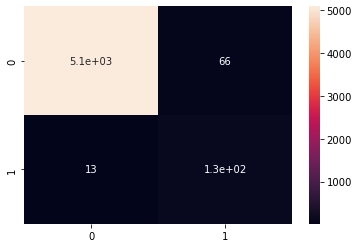

In [56]:
sns.heatmap(confusion_matrix(y_test, best_predict), annot=True)
plt.show()

Модернизирую функцию evaluate_preds для получения скоров с учетом лучшего вероятностного порога.

In [57]:
def evaluate_preds_with_threshold(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_poba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test,\
                                                           y_test_poba)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    best_predict = predict_proba_to_int(y_test_poba, thresholds[ix])
    

    get_classification_report(y_train, y_train_pred, y_test, best_predict)
    print('Best Threshold=%f' % (thresholds[ix]))
    
    return best_predict

In [58]:
evaluate_preds(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      7845
         1.0       0.63      0.91      0.75       203

    accuracy                           0.98      8048
   macro avg       0.82      0.95      0.87      8048
weighted avg       0.99      0.98      0.99      8048

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5158
         1.0       0.66      0.92      0.77       144

    accuracy                           0.99      5302
   macro avg       0.83      0.95      0.88      5302
weighted avg       0.99      0.99      0.99      5302

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     5091   67
1.0       12  132


In [59]:
best_predict = evaluate_preds_with_threshold(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      7845
         1.0       0.63      0.91      0.75       203

    accuracy                           0.98      8048
   macro avg       0.82      0.95      0.87      8048
weighted avg       0.99      0.98      0.99      8048

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5158
         1.0       0.66      0.91      0.77       144

    accuracy                           0.99      5302
   macro avg       0.83      0.95      0.88      5302
weighted avg       0.99      0.99      0.99      5302

CONFUSION MATRIX

col_0      0    1
target           
0.0     5092   66
1.0       13  131
Best Threshold=0.893577


Не удалось повысить метрику.

С трешхолдом нет смысла возиться.

In [60]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [61]:
y_test_poba = best_model.predict_proba(X_test)[:, 1]

Confusion matrix, without normalization
[[5091   67]
 [  12  132]]


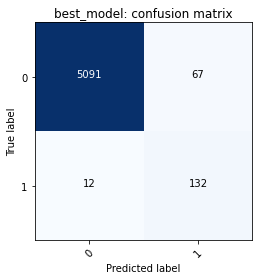

In [62]:
cm = confusion_matrix(y_test, y_test_poba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");

# СОЗДАЮ ПАЙПЛАЙН

На несбалансированных данных! 


In [79]:
columns8 = ['id', 'vas_id', 'buy_time_x', '0', '1', '2', '3', '4', '5', '6', '7',
     '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
     '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
     '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
     '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59',
     '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72',
     '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85',
     '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98',
     '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
     '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120',
     '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131',
     '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142',
     '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153',
     '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164',
     '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175',
     '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186',
     '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197',
     '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208',
     '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219',
     '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230',
     '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241',
     '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252',
     'time_delta', 'vas_id_01', 'vas_id_02', 'vas_id_04', 'vas_id_05', 'vas_id_06',
     'vas_id_07', 'vas_id_08', 'vas_id_09', 'month', 'day', 'weekofyear', 'time_max',
     'novelty', 'vas_id_day', 'is_action']

In [80]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [81]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [82]:
Selected_Columns = Pipeline([
                ('selector', ColumnSelector(columns8))
            ])

In [83]:
pipeline = Pipeline([
    ('Selected_Columns', Selected_Columns),
    ('classifier', catb.CatBoostClassifier(class_weights =  [1, 38.64532], random_state = 21, eval_metric = 'F1',  learning_rate = 0.001))
])

# Сохранение модели

In [4]:
import pickle

In [85]:
with open('model_8.pkl', 'wb') as model:
    pickle.dump(pipeline, model)

In [86]:
with open('model_8.pkl', 'rb') as model:
    x = pickle.load(model)

In [87]:
x.fit(X_test, y_test)

0:	learn: 0.9185437	total: 30.2ms	remaining: 30.2s
1:	learn: 0.9492242	total: 67.3ms	remaining: 33.6s
2:	learn: 0.9505508	total: 93.7ms	remaining: 31.1s
3:	learn: 0.9505508	total: 117ms	remaining: 29.2s
4:	learn: 0.9505508	total: 140ms	remaining: 27.9s
5:	learn: 0.9505508	total: 165ms	remaining: 27.3s
6:	learn: 0.9505508	total: 189ms	remaining: 26.8s
7:	learn: 0.9505508	total: 213ms	remaining: 26.5s
8:	learn: 0.9505508	total: 240ms	remaining: 26.4s
9:	learn: 0.9505508	total: 268ms	remaining: 26.6s
10:	learn: 0.9505508	total: 293ms	remaining: 26.4s
11:	learn: 0.9505508	total: 317ms	remaining: 26.1s
12:	learn: 0.9505508	total: 339ms	remaining: 25.8s
13:	learn: 0.9505508	total: 362ms	remaining: 25.5s
14:	learn: 0.9505508	total: 385ms	remaining: 25.3s
15:	learn: 0.9505508	total: 409ms	remaining: 25.1s
16:	learn: 0.9505508	total: 431ms	remaining: 24.9s
17:	learn: 0.9505508	total: 457ms	remaining: 25s
18:	learn: 0.9505508	total: 484ms	remaining: 25s
19:	learn: 0.9505508	total: 506ms	remainin

164:	learn: 0.9505508	total: 4.14s	remaining: 21s
165:	learn: 0.9505508	total: 4.17s	remaining: 20.9s
166:	learn: 0.9505508	total: 4.19s	remaining: 20.9s
167:	learn: 0.9505508	total: 4.22s	remaining: 20.9s
168:	learn: 0.9505508	total: 4.24s	remaining: 20.9s
169:	learn: 0.9505508	total: 4.27s	remaining: 20.8s
170:	learn: 0.9505508	total: 4.29s	remaining: 20.8s
171:	learn: 0.9505508	total: 4.32s	remaining: 20.8s
172:	learn: 0.9505508	total: 4.34s	remaining: 20.7s
173:	learn: 0.9505508	total: 4.37s	remaining: 20.7s
174:	learn: 0.9505508	total: 4.39s	remaining: 20.7s
175:	learn: 0.9505508	total: 4.42s	remaining: 20.7s
176:	learn: 0.9505508	total: 4.44s	remaining: 20.7s
177:	learn: 0.9505508	total: 4.46s	remaining: 20.6s
178:	learn: 0.9505508	total: 4.49s	remaining: 20.6s
179:	learn: 0.9505508	total: 4.51s	remaining: 20.6s
180:	learn: 0.9505508	total: 4.54s	remaining: 20.5s
181:	learn: 0.9505508	total: 4.56s	remaining: 20.5s
182:	learn: 0.9505508	total: 4.59s	remaining: 20.5s
183:	learn: 0.

323:	learn: 0.9505508	total: 7.97s	remaining: 16.6s
324:	learn: 0.9505508	total: 8.01s	remaining: 16.6s
325:	learn: 0.9505508	total: 8.04s	remaining: 16.6s
326:	learn: 0.9505508	total: 8.07s	remaining: 16.6s
327:	learn: 0.9505508	total: 8.1s	remaining: 16.6s
328:	learn: 0.9505508	total: 8.13s	remaining: 16.6s
329:	learn: 0.9505508	total: 8.15s	remaining: 16.6s
330:	learn: 0.9505508	total: 8.2s	remaining: 16.6s
331:	learn: 0.9505508	total: 8.23s	remaining: 16.6s
332:	learn: 0.9505508	total: 8.26s	remaining: 16.5s
333:	learn: 0.9505508	total: 8.28s	remaining: 16.5s
334:	learn: 0.9505508	total: 8.31s	remaining: 16.5s
335:	learn: 0.9505508	total: 8.34s	remaining: 16.5s
336:	learn: 0.9505508	total: 8.37s	remaining: 16.5s
337:	learn: 0.9505508	total: 8.4s	remaining: 16.5s
338:	learn: 0.9505508	total: 8.43s	remaining: 16.4s
339:	learn: 0.9505508	total: 8.46s	remaining: 16.4s
340:	learn: 0.9505508	total: 8.48s	remaining: 16.4s
341:	learn: 0.9505508	total: 8.5s	remaining: 16.4s
342:	learn: 0.95

482:	learn: 0.9505508	total: 12s	remaining: 12.9s
483:	learn: 0.9505508	total: 12.1s	remaining: 12.9s
484:	learn: 0.9505508	total: 12.1s	remaining: 12.8s
485:	learn: 0.9505508	total: 12.1s	remaining: 12.8s
486:	learn: 0.9505508	total: 12.1s	remaining: 12.8s
487:	learn: 0.9505508	total: 12.1s	remaining: 12.7s
488:	learn: 0.9505508	total: 12.2s	remaining: 12.7s
489:	learn: 0.9505508	total: 12.2s	remaining: 12.7s
490:	learn: 0.9505508	total: 12.2s	remaining: 12.7s
491:	learn: 0.9505508	total: 12.2s	remaining: 12.6s
492:	learn: 0.9505508	total: 12.3s	remaining: 12.6s
493:	learn: 0.9505508	total: 12.3s	remaining: 12.6s
494:	learn: 0.9505508	total: 12.3s	remaining: 12.6s
495:	learn: 0.9505508	total: 12.3s	remaining: 12.5s
496:	learn: 0.9505508	total: 12.4s	remaining: 12.5s
497:	learn: 0.9505508	total: 12.4s	remaining: 12.5s
498:	learn: 0.9505508	total: 12.4s	remaining: 12.4s
499:	learn: 0.9505508	total: 12.4s	remaining: 12.4s
500:	learn: 0.9505508	total: 12.4s	remaining: 12.4s
501:	learn: 0.

645:	learn: 0.9505508	total: 15.8s	remaining: 8.64s
646:	learn: 0.9505508	total: 15.8s	remaining: 8.61s
647:	learn: 0.9505508	total: 15.8s	remaining: 8.59s
648:	learn: 0.9505508	total: 15.8s	remaining: 8.56s
649:	learn: 0.9505508	total: 15.9s	remaining: 8.54s
650:	learn: 0.9505508	total: 15.9s	remaining: 8.51s
651:	learn: 0.9505508	total: 15.9s	remaining: 8.48s
652:	learn: 0.9505508	total: 15.9s	remaining: 8.46s
653:	learn: 0.9505508	total: 15.9s	remaining: 8.43s
654:	learn: 0.9505508	total: 16s	remaining: 8.41s
655:	learn: 0.9505508	total: 16s	remaining: 8.38s
656:	learn: 0.9505508	total: 16s	remaining: 8.36s
657:	learn: 0.9505508	total: 16s	remaining: 8.33s
658:	learn: 0.9505508	total: 16.1s	remaining: 8.31s
659:	learn: 0.9505508	total: 16.1s	remaining: 8.28s
660:	learn: 0.9505508	total: 16.1s	remaining: 8.26s
661:	learn: 0.9505508	total: 16.1s	remaining: 8.24s
662:	learn: 0.9505508	total: 16.2s	remaining: 8.21s
663:	learn: 0.9505508	total: 16.2s	remaining: 8.19s
664:	learn: 0.950550

812:	learn: 0.9505508	total: 19.7s	remaining: 4.53s
813:	learn: 0.9505508	total: 19.7s	remaining: 4.51s
814:	learn: 0.9505508	total: 19.8s	remaining: 4.48s
815:	learn: 0.9505508	total: 19.8s	remaining: 4.46s
816:	learn: 0.9505508	total: 19.8s	remaining: 4.43s
817:	learn: 0.9505508	total: 19.8s	remaining: 4.41s
818:	learn: 0.9505508	total: 19.8s	remaining: 4.38s
819:	learn: 0.9505508	total: 19.9s	remaining: 4.36s
820:	learn: 0.9505508	total: 19.9s	remaining: 4.33s
821:	learn: 0.9505508	total: 19.9s	remaining: 4.31s
822:	learn: 0.9505508	total: 19.9s	remaining: 4.29s
823:	learn: 0.9505508	total: 20s	remaining: 4.26s
824:	learn: 0.9505508	total: 20s	remaining: 4.24s
825:	learn: 0.9505508	total: 20s	remaining: 4.21s
826:	learn: 0.9505508	total: 20s	remaining: 4.19s
827:	learn: 0.9505508	total: 20s	remaining: 4.16s
828:	learn: 0.9505508	total: 20.1s	remaining: 4.14s
829:	learn: 0.9505508	total: 20.1s	remaining: 4.12s
830:	learn: 0.9505508	total: 20.1s	remaining: 4.09s
831:	learn: 0.9505508	

979:	learn: 0.9505508	total: 23.7s	remaining: 483ms
980:	learn: 0.9505508	total: 23.7s	remaining: 459ms
981:	learn: 0.9505508	total: 23.7s	remaining: 435ms
982:	learn: 0.9505508	total: 23.7s	remaining: 411ms
983:	learn: 0.9505508	total: 23.8s	remaining: 386ms
984:	learn: 0.9505508	total: 23.8s	remaining: 362ms
985:	learn: 0.9505508	total: 23.8s	remaining: 338ms
986:	learn: 0.9505508	total: 23.8s	remaining: 314ms
987:	learn: 0.9505508	total: 23.9s	remaining: 290ms
988:	learn: 0.9505508	total: 23.9s	remaining: 266ms
989:	learn: 0.9505508	total: 23.9s	remaining: 242ms
990:	learn: 0.9505508	total: 23.9s	remaining: 217ms
991:	learn: 0.9505508	total: 24s	remaining: 193ms
992:	learn: 0.9505508	total: 24s	remaining: 169ms
993:	learn: 0.9505508	total: 24s	remaining: 145ms
994:	learn: 0.9505508	total: 24s	remaining: 121ms
995:	learn: 0.9505508	total: 24s	remaining: 96.6ms
996:	learn: 0.9505508	total: 24.1s	remaining: 72.4ms
997:	learn: 0.9505508	total: 24.1s	remaining: 48.3ms
998:	learn: 0.95055

Pipeline(steps=[('Selected_Columns',
                 Pipeline(steps=[('selector',
                                  ColumnSelector(key=['id', 'vas_id',
                                                      'buy_time_x', '0', '1',
                                                      '2', '3', '4', '5', '6',
                                                      '7', '8', '9', '10', '11',
                                                      '12', '13', '14', '15',
                                                      '16', '17', '18', '19',
                                                      '20', '21', '22', '23',
                                                      '24', '25', '26', ...]))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7f00d7fb9f10>)])

Confusion matrix, without normalization
[[5091   67]
 [  12  132]]


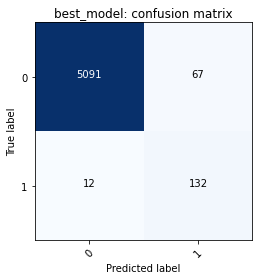

In [88]:
y_test_proba = x.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_test_proba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");

In [5]:
frozen_params = {
     'class_weights':[1, 38.645], 
     'silent':True,
     'random_state':21,
     #'cat_features': [],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [6]:
best_model = catb.CatBoostClassifier(**frozen_params, learning_rate = 0.001)

In [7]:
with open('model8.pkl', 'wb') as model:
    pickle.dump(best_model, model)

In [ ]:
with open('model8.pkl', 'rb') as model:
    loaded_model = pickle.load(model)

In [ ]:
y_test_proba = loaded_model.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_test_proba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");